# Kaggle -- blindness

https://www.kaggle.com/c/aptos2019-blindness-detection/overview

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [1]:
from fastai.vision import *

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [2]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Get data from kaggle seedling playground (not applicable for 2015 data)

In [ ]:
#!kaggle_setup.txt # setup kaggle account

In [4]:
#!kaggle competitions download -c aptos2019-blindness-detection

100%|█████████████████████████████████████▉| 7.99G/8.01G [01:55<00:00, 59.8MB/s]
100%|██████████████████████████████████████| 8.01G/8.01G [01:55<00:00, 74.4MB/s]
 98%|██████████████████████████████████████▎| 1.48G/1.50G [00:15<00:00, 142MB/s]
100%|███████████████████████████████████████| 1.50G/1.50G [00:15<00:00, 106MB/s]
  0%|                                               | 0.00/53.7k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 53.7k/53.7k [00:00<00:00, 40.1MB/s]
  0%|                                               | 0.00/24.5k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 24.5k/24.5k [00:00<00:00, 30.4MB/s]
  0%|                                               | 0.00/28.3k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 28.3k/28.3k [00:00<00:00, 37.4MB/s]


## Looking at the data

In [7]:
path = Path('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/blind/train_2015/2015')

In [8]:
path.ls()

[PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/blind/train_2015/2015/train'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/blind/train_2015/2015/trainLabels.csv')]

In [9]:
path_img = path/'train'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

In [10]:
fnames_train = get_image_files(path_img)

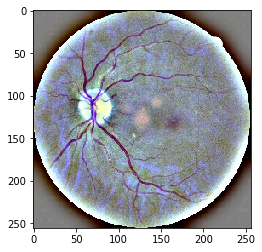

In [12]:
plt.imshow(plt.imread(str(fnames_train[30])))

## use Databunch api

In [14]:
train_df = pd.read_csv(path/'trainLabels.csv')
train_df.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [17]:
fnames_train[0]

PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/blind/train_2015/2015/train/20659_right.jpeg')

In [18]:
tfms = get_transforms(do_flip=True)
data = (ImageList.from_df(train_df, path_img, suffix='.jpeg')
        .split_by_rand_pct(0.2)
        .label_from_df()
        .transform(tfms, size=128)
        .databunch()
        .normalize(imagenet_stats))

In [19]:
print(data.classes)
len(data.classes),data.c

[0, 1, 2, 3, 4]


(5, 5)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 12 outputs).

We will train for 16 epochs (16 cycles through all our data).

In [20]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


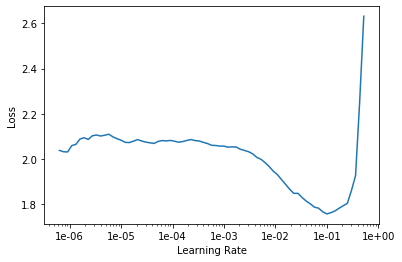

In [22]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, 5e-3) # this seems better than older versio of fastai, see part 1

epoch,train_loss,valid_loss,error_rate,time


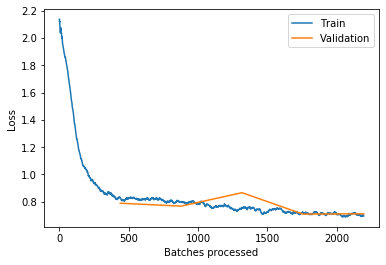

In [24]:
learn.recorder.plot_losses()

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [25]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()



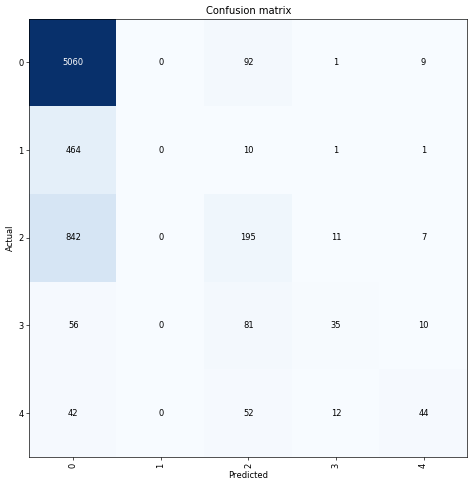

In [26]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [48]:
learn.unfreeze()

In [49]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.593676,0.490896,0.189891,02:25


In [ ]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.538680,0.477748,0.184426,02:27
1,0.530789,0.455665,0.180328,02:26
2,0.506330,0.441828,0.166667,02:27
3,0.480112,0.433832,0.148907,02:27
4,0.466197,0.432795,0.155738,02:27
5,0.453703,0.424344,0.154372,02:28


In [58]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.510775,0.506499,0.195355
2,0.494445,0.489590,0.192623
3,0.484813,0.477569,0.187158
4,0.470886,0.473189,0.184426
5,0.452026,0.473042,0.187158
6,0.433783,0.471709,0.180328
7,0.426697,0.470609,0.185792
8,0.408607,0.469107,0.178962
9,0.397636,0.465697,0.189891
10,0.396750,0.464890,0.185792


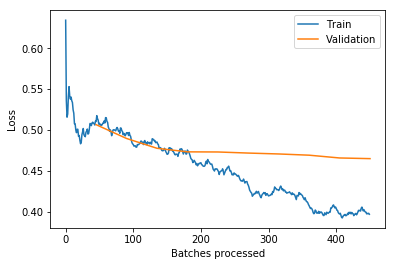

In [59]:
learn.recorder.plot_losses()

In [60]:
learn.save('blind_resnet34_unfreeze')

In [74]:
interp = ClassificationInterpretation.from_learner(learn)

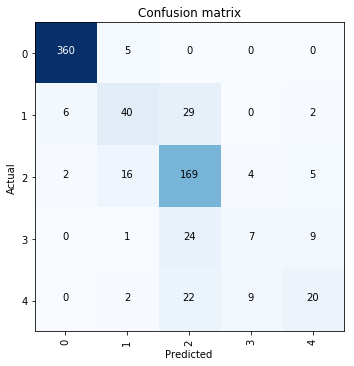

In [75]:
interp.plot_confusion_matrix(figsize=(5, 5))

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [62]:
# this can include the test set
tfms = get_transforms(do_flip=True) # do_flip=True by default. 
data2 = ImageDataBunch.from_csv(path=path_img, # path to all the train/valid images
                                   test='../test',
                                   suffix='.png',
                                   valid_pct=0.2, # hold out 20% for validation
                                   ds_tfms=tfms, 
                                   bs=bs//2, 
                                   size=229).normalize(imagenet_stats)


In [63]:
learn50 = create_cnn(data2, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


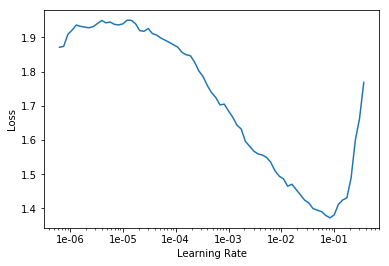

In [64]:
learn50.lr_find()
learn50.recorder.plot()

In [65]:
learn50.fit_one_cycle(16)

epoch,train_loss,valid_loss,error_rate
1,1.000232,0.735269,0.278689
2,0.829805,0.706841,0.250000
3,0.705712,0.604080,0.222678
4,0.650836,0.550774,0.215847
5,0.601470,0.540477,0.218579
6,0.604968,0.576876,0.229508
7,0.558166,0.532818,0.207650
8,0.514382,0.501778,0.191257
9,0.496488,0.485502,0.173497
10,0.451404,0.488573,0.189891


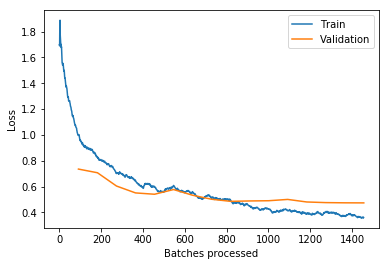

In [67]:
learn50.recorder.plot_losses()

In [66]:
learn50.save('seedling-resnet50-simple')

In [68]:
learn50.load('seedling-resnet50-simple')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (2929 items)
[Category 4, Category 1, Category 0, Category 0, Category 4]...
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/blind/train
x: ImageItemList (2929 items)
[Image (3, 2136, 3216), Image (3, 1736, 2416), Image (3, 1050, 1050), Image (3, 1536, 2048), Image (3, 2588, 3388)]...
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/blind/train;

Valid: LabelList
y: CategoryList (732 items)
[Category 0, Category 0, Category 2, Category 2, Category 4]...
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/blind/train
x: ImageItemList (732 items)
[Image (3, 1958, 2588), Image (3, 1536, 2048), Image (3, 2136, 3216), Image (3, 2136, 3216), Image (3, 1226, 1844)]...
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/blind/train;

Test: LabelList
y: CategoryList (1928 items)
[Category 4, Category 4, Category 4, Category 4, Category 4]...
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/blind/train
x: Ima

In [69]:
learn50.unfreeze()
learn50.fit_one_cycle(5, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.410978,0.528684,0.189891
2,0.460663,0.536453,0.218579
3,0.403093,0.519130,0.176230
4,0.321341,0.482920,0.173497
5,0.262475,0.485814,0.169399


In [70]:
learn50.save('seedling_resnet50-unfreeze');

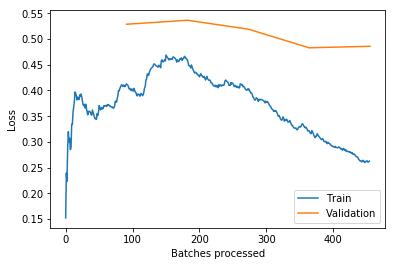

In [72]:
learn50.recorder.plot_losses()

In [71]:
interp = ClassificationInterpretation.from_learner(learn50)

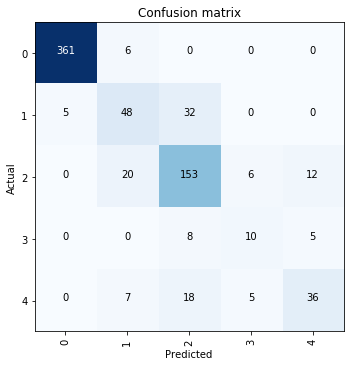

In [73]:
interp.plot_confusion_matrix(figsize=(5, 5))

resnet50 unfreeze is beter than resnet34 simple

## Choose a better transform combination

In [9]:
tfms = get_transforms(do_flip=True, 
                      flip_vert=True, 
                      max_rotate=175, 
                      max_zoom=1, 
                      max_lighting=None, 
                      max_warp=None, 
                      p_affine=0.5, 
                      p_lighting=0.75)
data2 = ImageDataBunch.from_csv(path=path_img, # path to all the train/valid images
                                suffix='.png',
                                valid_pct=0.2, # hold out 20% for validation
                                ds_tfms=tfms, 
                                bs=bs, 
                                size=229).normalize(imagenet_stats)

In [10]:
learn50 = create_cnn(data2, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


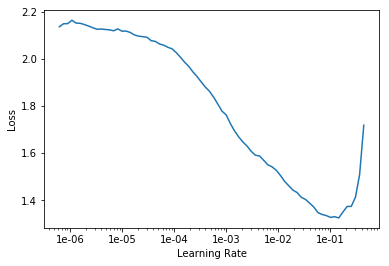

In [11]:
learn50.lr_find()
learn50.recorder.plot()

In [12]:
learn50.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate
1,1.056465,0.801359,0.255464
2,0.802563,0.612804,0.226776
3,0.680020,0.573808,0.224044
4,0.599810,0.548399,0.211749
5,0.551495,0.537564,0.200820


In [13]:
# valid loss is smaller than train loss. keep going
learn50.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate
1,0.507012,0.556706,0.211749
2,0.522041,0.539730,0.214481
3,0.517524,0.550083,0.211749
4,0.497294,0.510152,0.200820
5,0.465685,0.513635,0.199454


In [14]:
learn50.save('blind-resnet50-simple')

In [15]:
learn50.unfreeze()
learn50.fit_one_cycle(5, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.451895,0.506369,0.193989
2,0.452439,0.561829,0.198087
3,0.439881,0.494411,0.184426
4,0.389751,0.479488,0.183060
5,0.338679,0.476585,0.178962


In [17]:
interp = ClassificationInterpretation.from_learner(learn50)

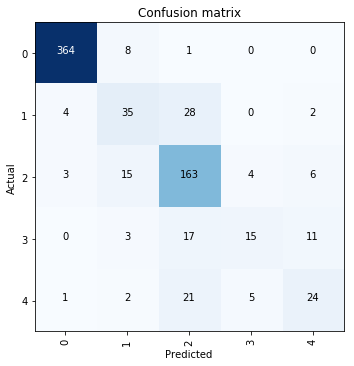

In [18]:
interp.plot_confusion_matrix(figsize=(5, 5))

In [19]:
learn50.save('blind-resnet50-unfreeze-20190701')

In [20]:
learn50.fit_one_cycle(5, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.322619,0.500289,0.184426
2,0.346956,0.566226,0.198087
3,0.327155,0.496905,0.176230
4,0.272493,0.504291,0.169399
5,0.234259,0.497540,0.176230


In [21]:
learn50.save('blind-resnet50-unfreeze-20190701b')

## choose bigger image size

In [7]:
tfms = get_transforms(do_flip=True, 
                      flip_vert=True, 
                      max_rotate=175, 
                      max_zoom=1, 
                      max_lighting=None, 
                      max_warp=None, 
                      p_affine=0.5, 
                      p_lighting=0.75)
data2 = ImageDataBunch.from_csv(path=path_img, # path to all the train/valid images
                                suffix='.png',
                                valid_pct=0.2, # hold out 20% for validation
                                ds_tfms=tfms, 
                                bs=bs//4, 
                                size=512).normalize(imagenet_stats)

In [8]:
learn50 = create_cnn(data2, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


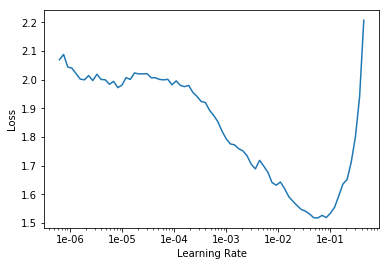

In [9]:
learn50.lr_find()
learn50.recorder.plot()

In [10]:
learn50.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate
1,0.903042,0.619076,0.237705
2,0.690501,0.534794,0.218579
3,0.623482,0.505836,0.192623
4,0.579248,0.466761,0.189891
5,0.535070,0.468917,0.185792


In [11]:
learn50.save('blind512-resnet50-simple')

In [12]:
interp = ClassificationInterpretation.from_learner(learn50)

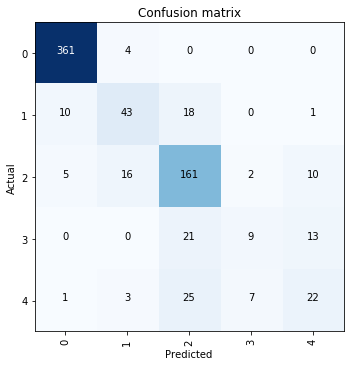

In [13]:
interp.plot_confusion_matrix(figsize=(5,5))

In [14]:
learn50.unfreeze()

In [15]:
learn50.fit_one_cycle(5, max_lr=slice(1e-5,1e-3)) #out of memory

epoch,train_loss,valid_loss,error_rate


RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB (GPU 0; 7.43 GiB total capacity; 6.88 GiB already allocated; 26.94 MiB free; 22.35 MiB cached)

## choose bigger image size using resnet34 as it is better than resnet50 on the leader board

In [8]:
# this can include the test set
tfms = get_transforms(do_flip=True) # do_flip=True by default. 
data2 = ImageDataBunch.from_csv(path=path_img, # path to all the train/valid images
                                   test='../test',
                                   suffix='.png',
                                   valid_pct=0.2, # hold out 20% for validation
                                   ds_tfms=tfms, 
                                   bs=bs//4, 
                                   size=512).normalize(imagenet_stats)

In [9]:
learn = create_cnn(data2, models.resnet34, metrics=error_rate)

In [10]:
learn.fit_one_cycle(10, 5e-3)

epoch,train_loss,valid_loss,error_rate
1,0.842070,0.662629,0.224044
2,0.702743,0.609376,0.258197
3,0.618812,0.551130,0.203552
4,0.667774,0.546816,0.206284
5,0.585957,0.461735,0.181694
6,0.593591,0.457773,0.185792
7,0.502003,0.452363,0.155738
8,0.486081,0.418283,0.163934
9,0.450098,0.402881,0.158470
10,0.418966,0.397509,0.166667


In [11]:
learn.save('resnet34-512-simple-long')

In [12]:
interp = ClassificationInterpretation.from_learner(learn)

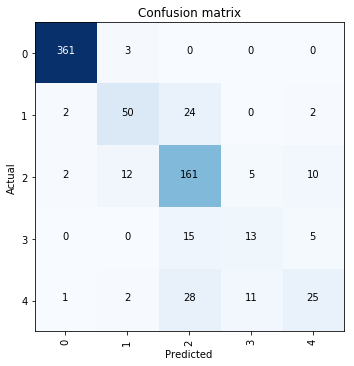

In [13]:
interp.plot_confusion_matrix(figsize=(5,5))

In [15]:
learn.load('resnet34-512-simple')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (2929 items)
[Category 1, Category 0, Category 4, Category 0, Category 2]...
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/blind/train
x: ImageItemList (2929 items)
[Image (3, 1736, 2416), Image (3, 1536, 2048), Image (3, 2588, 3388), Image (3, 1958, 2588), Image (3, 1958, 2588)]...
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/blind/train;

Valid: LabelList
y: CategoryList (732 items)
[Category 2, Category 0, Category 0, Category 0, Category 2]...
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/blind/train
x: ImageItemList (732 items)
[Image (3, 2588, 3388), Image (3, 1050, 1050), Image (3, 1050, 1050), Image (3, 1050, 1050), Image (3, 2136, 3216)]...
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/blind/train;

Test: LabelList
y: CategoryList (1928 items)
[Category 1, Category 1, Category 1, Category 1, Category 1]...
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/blind/train
x: Ima

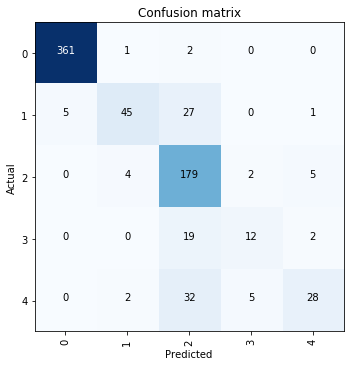

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5))

## try resnet101

In [7]:
tfms = get_transforms(do_flip=True) # do_flip=True by default. 
data2 = ImageDataBunch.from_csv(path=path_img, # path to all the train/valid images
                                   suffix='.png',
                                   valid_pct=0.2, # hold out 20% for validation
                                   ds_tfms=tfms, 
                                   bs=bs//4, 
                                   size=229).normalize(imagenet_stats)

In [8]:
learn = create_cnn(data2, models.resnet101, metrics=error_rate)

In [9]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


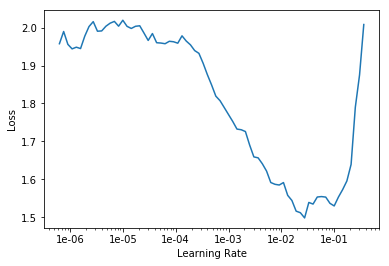

In [10]:
learn.recorder.plot(suggestino=True)

In [9]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,error_rate
1,0.812399,1.082381,0.393443
2,0.776067,0.731143,0.306011
3,0.651502,0.535509,0.195355
4,0.572751,0.493347,0.183060
5,0.462315,0.476665,0.174863


In [12]:
valid_preds= learn.get_preds(DatasetType.Valid)

In [16]:
X_p = np.copy(valid_preds[0])

In [17]:
X_p[0]

array([0.015495, 0.360571, 0.610971, 0.004231, 0.008732], dtype=float32)

In [15]:
learn.save('resnet101-simple')

### try kappa

In [18]:
import numpy as np
import pandas as pd
import os
import scipy as sp
from functools import partial
from sklearn import metrics
from collections import Counter
import json

In [54]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        y_hat = np.copy(y)
        for i, predprob in enumerate(X_p):
            pred = np.inner(predprob, np.linspace(0,4,5))
            if pred < coef[0]:
                y_hat[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                y_hat[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                y_hat[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                y_hat[i] = 3
            else:
                y_hat[i] = 4

        ll = metrics.cohen_kappa_score(y, y_hat, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        X_p = np.copy(X)
        y_hat = np.copy(X_p[:, 0])
        for i, predprobs in enumerate(X_p):
            pred = np.inner(predprobs, np.linspace(0,4,5))
            if pred < coef[0]:
                y_hat[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                y_hat[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                y_hat[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                y_hat[i] = 3
            else:
                y_hat[i] = 4
        return y_hat

    def coefficients(self):
        return self.coef_['x']


In [55]:
optR = OptimizedRounder()
optR.fit(valid_preds[0],valid_preds[1])

0.9045309971944215


In [62]:
optR.coefficients()

array([0.550234, 1.575291, 2.265805, 3.433257])

In [56]:
optR.predict(valid_preds[0], optR.coefficients())

array([2., 3., 0., 0., ..., 2., 0., 0., 0.], dtype=float32)

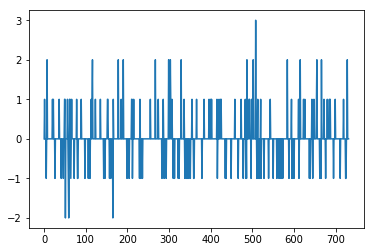

In [61]:
plt.plot(valid_preds[1].numpy()-optR.predict(valid_preds[0], optR.coefficients()))

In [31]:
X_p[1]

array([0.21753 , 0.014307, 0.085737, 0.16676 , 0.515666], dtype=float32)

In [32]:
np.inner(X_p[1], np.linspace(0, 4, 5))

2.7487235702574253

In [37]:
pred

NameError: name 'pred' is not defined